In [1]:
# !pip install torch==2.1.2 torchvision rasterio

In [2]:
# !pip install ollama

In [3]:
# ! pip uninstall torch -y
# 

In [4]:
import os


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import rasterio as rio
import glob
import torch
from torch.utils.data import DataLoader, Dataset, random_split
import torch
import torchvision.transforms as transforms
from torchvision import transforms

from rasterio.plot import reshape_as_image
from PIL import Image

# file locations
DATA_PATH = "drive/MyDrive/AIML24"
TRAINING_PATH = DATA_PATH + "/remote_sensing/otherDatasets/sentinel_2/tif"
TEST_PATH = DATA_PATH + "/remote_sensing/otherDatasets/sentinel_2/testset"

# mount g-drive
try:
    from google.colab import drive
    drive.mount('/content/drive')

    # copy files into runtime for performance
    !cp "drive/MyDrive/AIML24" "AIML24"
    DATA_PATH = "AIML24"
except:
    pass # probably local environment



def load_img(img_path:str) -> np.ndarray:
  if img_path.split('.')[-1] == "tif":
    with rio.open(img_path, "r") as d:
      img = d.read([1,2,3,4,5,6,7,8,9,10,11,12,13])
      img = reshape_as_image(img)
  else:
    img = np.load(img_path)
  return img


ids2labels = {
    0: 'AnnualCrop',
    1: 'Forest',
    2: 'HerbaceousVegetation',
    3: 'Highway',
    4: 'Industrial',
    5: 'Pasture',
    6: 'PermanentCrop',
    7: 'Residential',
    8: 'River',
    9: 'SeaLake'
}

labels2ids = {v: k for k, v in ids2labels.items()}

def text2oh(label):
    one_hot = np.zeros(10)
    one_hot.put(labels2ids[label], 1)
    return one_hot

def oh2text(one_hot):
    try:
        one_hot = one_hot["ID"]
    except:
        pass
    try:
        one_hot = one_hot.numpy()
    except:
        pass
    idx = np.argmax(one_hot)
    return ids2labels[idx]

class SentinelTrain(Dataset):
    def __init__(self, transformations=None):
        self.img_paths = [path.replace('\\', '/') for path in glob.glob(os.path.join(TRAINING_PATH, "*", f"*.tif"))]
        self.transformations = transformations

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = load_img(img_path).astype(np.float32)

        if self.transformations:
            image = self.transformations(image)

        label = img_path.split("/")[-1].split("_")[0]
        one_hot = text2oh(label)
        # return image, one_hot
        channels = torch.tensor([c for c in range(12)])
        return image, {"ID": one_hot, "channels": channels}



def get_id(img_path):
    return img_path.split("/")[-1].split("_")[-1].split(".")[0]

class SentinelTest(Dataset):
    def __init__(self, transformations=None):
        self.img_paths = [path.replace("\\","/") for path in glob.glob(os.path.join(TEST_PATH,  f"*.npy"))]
        self.transformations = transformations
    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = load_img(img_path).astype(np.float32)
        image_id = get_id(img_path)

        if self.transformations:
            image = self.transformations(image)
        return image, image_id


# Create instances of the Dataset Class for both train & test


def bandselect(img):
    return img[:, :, [3,2,1]]

def convert_to_float(img):
    return img / 10000.0

def bands_to_front(img):
    return img.permute(2, 0, 1)

# TODO: improvement -> find global max / min
def l2a_approx(img):
    l2a_bands = img[:,:,[0,1,2,3,4,5,6,7,12,8,10,11]]
    return l2a_bands
    # band_min = np.min(l2a_bands, (0,1)) # minimal value per band
    # return l2a_bands - band_min # dark object subtraction algo approximation

train_mean = [1353.7283, 1117.2009, 1041.8888,  946.5547, 1199.1866, 2003.0106,
        2374.0134, 2301.2244, 2599.7827,  732.1823, 1820.6930, 1118.2052]
train_std = [ 65.2964, 153.7740, 187.6989, 278.1234, 227.9242, 355.9332, 455.1324,
        530.7811, 502.1637,  98.9300, 378.1612, 303.1070]
test_mean = [380.1732,  400.1498,  628.8646,  578.8707,  943.4276, 1826.2419,
        2116.6646, 2205.9729, 2281.1836, 2266.9331, 1487.6902,  959.2352]
test_std = [115.1743, 209.1482, 241.2069, 301.1053, 269.5137, 420.2494, 503.8187,
        598.0409, 529.4133, 403.9382, 398.1438, 342.4408]


def normalize_for_display(band_data):
    """Normalize multi-spectral imagery across bands.
    The input is expected to be in HxWxC format, e.g. 64x64x13.
    To account for outliers (e.g. extremly high values due to
    reflective surfaces), we normalize with the 2- and 98-percentiles
    instead of minimum and maximum of each band.
    """
    band_data = np.array(band_data)
    lower_perc = np.percentile(band_data, 2, axis=(0,1))
    upper_perc = np.percentile(band_data, 98, axis=(0,1))

    return (band_data - lower_perc) / (upper_perc - lower_perc)

train_transforms = transforms.Compose([
    l2a_approx,
    # transforms.Normalize(train_mean, train_std),
    transforms.ToTensor(),
    transforms.GaussianBlur(1),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
])

train_dataset = SentinelTrain(train_transforms)


test_transforms  = transforms.Compose([

    normalize_for_display,
    transforms.ToTensor(),
    # transforms.Normalize(test_mean, test_std),
    transforms.GaussianBlur(1),
])

test_dataset = SentinelTest(test_transforms)

print(len(train_dataset))
print(len(test_dataset))





# train_dataset_subset, val_dataset_subset = random_split(train_dataset, [.8, .2])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_dataloader = DataLoader(val_dataset_subset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Utility function to display image from dataset
from rasterio.plot import reshape_as_image


def print_image(img, label, rgb_bands=[3,2,1])-> None:
  """Displays an image. Indices of bands given by "rgb_bands" will be displayed as RGB in the print
  """
  img = img.numpy()
  img = img.transpose(1,2,0)
#   img = normalize_for_display(img)
  img = img[:, :, rgb_bands]
  fig, ax = plt.subplots(1, figsize=(5,5))
  ax.imshow((img * 255).astype(np.uint8), vmin=0, vmax=255)

  label = oh2text(label["ID"])
  ax.set_title(label)
  ax.axis(False)
  plt.tight_layout()

  plt.show()

27000
4232


<Axes: ylabel='Count'>

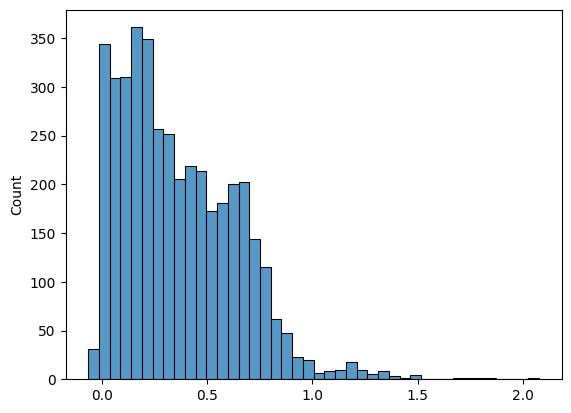

In [5]:
import seaborn as sns
sns.histplot(test_dataset.__getitem__(30)[0][2].flatten())

In [6]:


def img2b64(img):
    rgb_bands = [3,2,1]



    img = img.numpy()
    img = img.transpose(1,2,0)
    img = normalize_for_display(img)
    img = img[:, :, rgb_bands]
    # fig, ax = plt.subplots(1, figsize=(5,5))
    # img = plt.imshow((img * 255).astype(np.uint8), vmin=0, vmax=255)
    img = plt.imshow(img, vmin=0, vmax=255)



    plt.axis('off')
    plt.tight_layout()
    # plt.savefig("test.png", bbox_inches='tight')

    import io
    import base64
    my_stringIObytes = io.BytesIO()
    plt.savefig(my_stringIObytes, format='jpg')
    my_stringIObytes.seek(0)
    my_base64_jpgData = base64.b64encode(my_stringIObytes.read()).decode()
    return my_base64_jpgData



<Axes: ylabel='Count'>

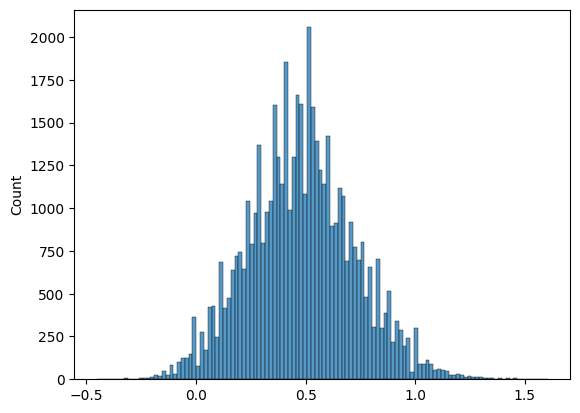

In [7]:
import seaborn as sns

sns.histplot(test_dataset.__getitem__(4200)[0].flatten())

Few shot binary classification

1. focus on single label at a time
2. Show examples of 1.0

In [8]:
# import ollama

# ollama.pull('llama3')
# ollama.pull('llama3:70b')

# ollama.pull('llava')
# ollama.pull('llava:34b')
# ollama.pull('llava:13b')



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

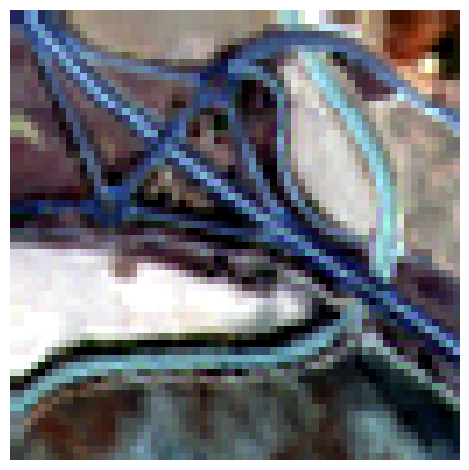

In [9]:

from collections import defaultdict
img, label = test_dataset.__getitem__(2000)
imgb64 = img2b64(img)

init_prompt = """
The following image is a sattelite image from the Sentinel 2 sattelite. The task is to classify the land use into predefined categories

Available classes are:
AnnualCrop
Forest
HerbaceousVegetation
Highway
Industrial
Pasture
PermanentCrop
Residential
River
SeaLake

The following are example images and classes.
"""
# ollama.chat(model="llava", prompt=prompt, images=[imgb64])['response']

initial_message = {
			'role': 'user',
			'content': init_prompt,
			'images': []
		}

q = f"""From the list of land use categories provided earlier, what description fits this image best? Anser by providing the class label exactly as stated. 

Available classes are:
AnnualCrop
Forest
HerbaceousVegetation
Highway
Industrial
Pasture
PermanentCrop
Residential
River
SeaLake

If unsure which label to predict, choose the one that has the highest likelihood.
"""

examples = [5, 700, 2000, 2400, 3500, 4500, 6000, 7000, 8000, 9000, 10000, 11000, 13000, 14000, 16000, 17000, 19000, 20000, 22000, 23000, 25000, 26000]


images = defaultdict(list)
for example in examples:
    img, label = train_dataset.__getitem__(example)
    imgb64 = img2b64(img)
    label = oh2text(label["ID"])
    images[label].append(imgb64)

classes = list(images.keys())

negative_examples = {
    "AnnualCrop": [images["Pasture"][0], images["PermanentCrop"][0]],
    "Forest": [images["Industrial"][0], images["SeaLake"][0]],
    "HerbaceousVegetation": [images["AnnualCrop"][0], images["PermanentCrop"][0]],
    "Highway": [images["Pasture"][0], images["River"][0]],
    "Industrial": [images["Forest"][0], images["Residential"][0]],
    "Pasture": [images["AnnualCrop"][0], images["PermanentCrop"][0]],
    "PermanentCrop": [images["Pasture"][0], images["AnnualCrop"][0]],
    "Residential": [images["Industrial"][0], images["Forest"][0]],
    "River": [images["Highway"][0], images["Pasture"][0]],
    "SeaLake": [images["Forest"][0], images["Industrial"][0]]
}

# example_messages = []

# for l, i in images:
#     q_message = {
# 			'role': 'user',
# 			'content': q,
# 			'images': [i]
# 		}
#     a_message = {
# 			'role': 'assistant',
# 			'content': f"{l}",
# 			'images': [i]
# 		}
#     example_messages.append(q_message)
#     example_messages.append(a_message)

In [10]:
# embellish prompt
import ollama
l = "River"

embellish_q = f"Describe in a few sentences what you would expect a sattelite image displaying {l} to look like. Describe the main Features and how such images could be differentiated from other types of land use."

r = ollama.generate(model="llama3", prompt=embellish_q)
embellish_a = r["response"]


binary_prompt = f"""
    You are an expert in detecting {l} in low quality sattelite images. {embellish_a}
    Does the image show {l}?
    Verify the correctness of the Answer.
    Answer by giving a likelihood ranging from 0.0 to 1.0, do not provide any other sentences.
"""

img, label = train_dataset.__getitem__(3000)
imgb64 = img2b64(img)
r = ollama.generate(model="llava", prompt=binary_prompt, images=[imgb64])
r["response"]

KeyboardInterrupt: 

In [ ]:
c = "SeaLake"
r = ollama.generate(model="llama3", prompt=f"Rewrite the following word into a plural form to use it in a sentence. If necessary, split the word into multiple words, without loosing any of its meaning. Multiple words can be separated by the word and. The word is {c} Answer by providing the plural versions of the word only, without writing any other text.")

In [ ]:
class_plurals = {
    'Pasture': "pastures",
    'River': "rivers",
    'SeaLake': "the sea or lakes",
    'PermanentCrop': "permanent crops",
    'Industrial': "industrial areas",
    'HerbaceousVegetation': "herbaceous vegetation",
    'Forest': "forests",
    'Residential':"residential areas",
    'AnnualCrop': "annual crops",
    'Highway': "highways"
}

def embellish_description(l):    
    embellish_q = f"Describe in a few sentences what you would expect a low quality sattelite image from the Eurosat Dataset displaying {class_plurals[l]} to look like. \
        Describe the main features, the expected colors and how such images could be differentiated from other types of land use."

    r = ollama.generate(model="llama3", prompt=embellish_q)
    embellish_a = r["response"]
    return embellish_a


# class_prompts = {c:  for c in classes}



class_history = defaultdict(list)
for c in classes:
    # binary_example_q = class_prompts[c]
    # binary_example_a = "1.0"
    # binary_example_na = "0.0"

    class_history[c].append({
			'role': 'user',
			'content': f"""
You are an expert in detecting {class_plurals[c]} in low quality sattelite images. {embellish_description(c)}
f"What is the likelihood that  the image shows {class_plurals[c]}? Answer by giving a number from 0.0 to 1.0, with 0.0 indicating no presence of {class_plurals[c]} and 1.0 indicating a absolute certainty that it shows {class_plurals[c]}.

Answer by giving a likelyhood ranging from 0.0 to 1.0, with 0.0 indicating no presence of {class_plurals[c]} and 1.0 indicating a absolute certainty that it shows {class_plurals[c]}.\
If you are unsure, use a value of 0.0.
Do not provide any other information apart from the score.
""",
			'images': images[c]
		})
    class_history[c].append({
			'role': 'assistant',
			'content': "1.0",
		})
    class_history[c].append({
			'role': 'user',
			'content': f"What is the likelihood that  the image shows {class_plurals[c]}? Answer by giving a number from 0.0 to 1.0, with 0.0 indicating no presence of {class_plurals[c]} and 1.0 indicating a absolute certainty that it shows {class_plurals[c]}. Return the number only.",
			'images': negative_examples[c]
		})
    class_history[c].append({
			'role': 'assistant',
			'content': "0.0",
		})



In [27]:


class_examples = {
    'AnnualCrop': [100, 116],
    'Pasture': [1035, 1037],
    'River': [136, 1017],
    'SeaLake': [102, 137],
    'PermanentCrop': [51, 1030],
    'Industrial': [1008, 1022],
    'HerbaceousVegetation': [1016],
    'Forest': [163,175],
    'Residential': [99, 1006],
    'Highway': [112, 1024]
}
# class_examples = {
#     'AnnualCrop': [100],
#     'Pasture': [1035],
#     'River': [136],
#     'SeaLake': [102],
#     'PermanentCrop': [1013],
#     'Industrial': [1008],
#     'HerbaceousVegetation': [1016],
#     'Forest': [101,],
#     'Residential': [99],
#     'Highway': [112]
# }

class Conversation():

    def __init__(self, model):
        self.model = model
        self.context = None

    def reply(self, prompt, images=[], save_ctx=True):
        # print(f"{prompt} \n images {len(images)}")
        res = ollama.generate(model=self.model, prompt=prompt, images=images, context=self.context, options={"num_ctx": 10000, "temperature":0})
        if save_ctx:
            self.context = res["context"]
        print(f"{res['total_duration'] / 1e9} seconds")
        return res["response"]


class_plurals = {
    'Pasture': "pastures",
    'River': "rivers",
    'SeaLake': "the sea or lakes",
    'PermanentCrop': "permanent crops",
    'Industrial': "industrial areas",
    'HerbaceousVegetation': "herbaceous vegetation",
    'Forest': "forests",
    'Residential':"residential areas",
    'AnnualCrop': "annual crops",
    'Highway': "highways"
}

def embellish_description(l):    
    embellish_q = f"Describe in a few sentences what you would expect a low quality sattelite image from the Eurosat Dataset displaying {class_plurals[l]} to look like. \
        Describe the main features, the expected colors and how such images could be differentiated from other types of land use."

    r = ollama.generate(model="llama3", prompt=embellish_q)
    embellish_a = r["response"]
    return embellish_a

def prime_prompt(c):
    return f"You are an expert in detecting {class_plurals[c]} in low quality sattelite images. {embellish_description(c)} \n \
    The images provided are examples of an image showing primarily {class_plurals[c]}"

def binary_prompt(c):
    return f"Does the image show {class_plurals[c]}? \n \
    Take into account the images provided as examples earlier. \n \
    Carefully consider the features that indicate the presence of {class_plurals[c]} as well as the features pointing towards a different type of land use. \n \
    Answer by giving only a value from 0.0 (meaning there is little evidence for it to contain \
    {class_plurals[c]}) to 1.0 (contains primarily {class_plurals[c]} with high certainty). \
    Return only the likelihood value and no additional information.\
    \n Value:"


class BinaryClassifier():

    def __init__(self, cls, model):
        self.cls = cls
        self.conv = Conversation(model)

    def prime(self, examples):
        imgs = [test_dataset.__getitem__(example)[0] for example in examples]
        imgsb64 = [img2b64(img) for img in imgs]
        prompt = prime_prompt(self.cls)
        self.conv.reply(prompt=prompt, images=imgsb64)

    def predict(self, img):
        imgb64 = img2b64(img)
        # print(binary_prompt(self.cls))
        return (self.cls, self.conv.reply(prompt=binary_prompt(self.cls), images=[imgb64], save_ctx=False))


# # model = "llava:34b"
# model = "llava:13b"
# # model = "llava"
# conv = Conversation(model)

# for c, imgs in class_examples.items():
#     # print(imgs)
#     imgsb64 = [img2b64(test_dataset.__getitem__(i)[0]) for i in imgs]
#     # print(len(str(imgsb64)))
#     print(c)
#     conv.reply(f"""The following image is a sattelite image from the Sentinel 2 sattelite. The task is to classify the land use into predefined categories.
               
# Consider the image carfully and decide which class would be the most fitting for tis image.

# Available classes are:
# AnnualCrop
# Forest
# HerbaceousVegetation
# Highway
# Industrial
# Pasture
# PermanentCrop
# Residential
# River
# SeaLake

# These images show examples of the class "{c}", more examples will follow.

#     """, imgsb64)




In [32]:
from joblib import Parallel, delayed



class ExpertGroup():

    def __init__(self, model):
        self.experts = {}
        self.model= model

    def prime(self, examples):
        def prime_expert(c, imgs):
            expert = BinaryClassifier(c, self.model)
            expert.prime(imgs)
            return expert
        
        tasks = [delayed(prime_expert)(c, imgs) for c, imgs in examples.items()]
        # print(tasks)
        results = Parallel(n_jobs=len(tasks))(tasks)
        self.experts = {expert.cls: expert for expert in results}

    def predict(self, img):
        tasks = [delayed(expert.predict)(img) for _, expert in self.experts.items()]
        results = Parallel(n_jobs=len(tasks))(tasks)
        return {t[0]: t[1] for t in results}


In [36]:
def take_best_class(res):
    best_value = .0
    best_class = None

    for c, val in res.items():
        if val > best_value:
            best_value = val
            best_class = c
    
    
# model = "llava:13b"
model = "llava:34b-v1.6"
expert_group = ExpertGroup(model)
expert_group.prime(class_examples)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

27.103543339 seconds
13.159376042 seconds
18.994468266 seconds
16.158000418 seconds
15.25685101 seconds
16.881797397 seconds
15.847339114 seconds
16.764790306 seconds
21.596823683 seconds
15.978080178 seconds


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

3.516536973 seconds
3.508465825 seconds
3.852380822 seconds
3.505611262 seconds
3.60671489 seconds
3.625897912 seconds
3.744847321 seconds
3.659815976 seconds
3.611368648 seconds
3.685074821 seconds


{'AnnualCrop': '0.1',
 'Pasture': '0.3',
 'River': '0.3',
 'SeaLake': '0.2',
 'PermanentCrop': '0.2',
 'Industrial': '0.0',
 'HerbaceousVegetation': '0.3',
 'Forest': '0.5',
 'Residential': '0.3',
 'Highway': '0.1'}

In [44]:
def take_best_class(res):
    best_value = .0
    best_class = None

    for c, val in res.items():
        try:
            val = float(val)
        except:
            print(f"For {c}, no value was found: {val}")
            continue
        if val > best_value:
            best_value = val
            best_class = c
            img, ids= test_dataset.__getitem__(181)

    return best_value, best_class

img, ids= test_dataset.__getitem__(50)

preds = expert_group.predict(img)
take_best_class(preds)

_ = img2b64(img)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

3.635833105 seconds
3.508996915 seconds
3.509132624 seconds
3.664019762 seconds
3.699377496 seconds
3.658739358 seconds
3.612800857 seconds
3.61526265 seconds
3.680909727 seconds
3.601397675 seconds


(0.7, 'Pasture')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


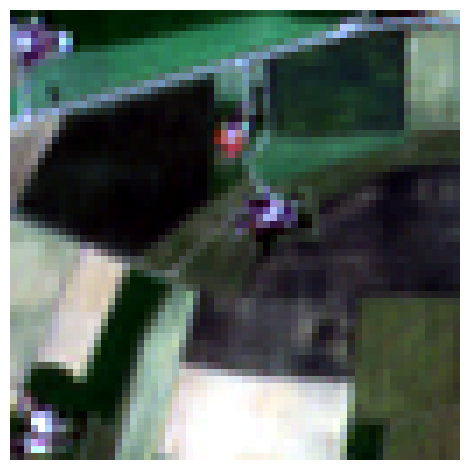

In [45]:
_ = img2b64(img)

In [46]:
classArray = []

for i in range(len(test_dataset.img_paths)):
    img, img_id = test_dataset.__getitem__(i)
    preds = expert_group.predict(img)
    pred = take_best_class(preds)

    print(pred)
    # img_ids = [get_id(path) for path in paths]
    # preds = model(imgs.to("cuda"))
    # preds = list(preds.logits.detach())
    # preds = [oh2text(pred.detach().cpu()) for pred in preds]
    classArray.append((img_id, pred))

import csv
from datetime import datetime

execution_start = datetime.now().strftime("%m%d%Y-%H%M%S")
with open(f'{execution_start}.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['test_id', 'label'])

    # Write each string to a row with its corresponding index as the test_id
    for i, label in classArray:
        writer.writerow([i, label])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

16.49306696 seconds
3.438903564 seconds
3.67771076 seconds
3.427567653 seconds
3.544540457 seconds
3.587957448 seconds
3.784640579 seconds
3.611379941 seconds
3.538040645 seconds
3.534152772 seconds
(0.7, 'Industrial')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

3.424182785 seconds
3.466886884 seconds
3.415057795 seconds
3.539814797 seconds
3.619736702 seconds
3.579191584 seconds
3.596435269 seconds
3.622859194 seconds
3.543422834 seconds
3.529593091 seconds
(0.5, 'Pasture')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

3.38464957 seconds
3.429434156 seconds
3.421427838 seconds
3.59634353 seconds
3.540168726 seconds
3.535864639 seconds
3.584892655 seconds
3.543008599 seconds
3.623653274 seconds
3.615974987 seconds
(0.3, 'Residential')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

3.3955335 seconds
3.433983966 seconds
3.442985567 seconds
3.598166961 seconds
3.590689578 seconds
3.543115809 seconds
3.538259361 seconds
3.62624763 seconds
3.616982796 seconds
3.539649134 seconds
(0.7, 'Pasture')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

3.393094288 seconds
3.426362515 seconds
3.590533393 seconds
3.590350488 seconds
3.625551392 seconds
3.425872668 seconds
3.545001455 seconds
3.636280962 seconds
3.56025868 seconds
3.54448577 seconds
(0.5, 'Pasture')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

3.384009882 seconds
3.421462546 seconds
3.435629825 seconds
3.5932994 seconds
3.543906287 seconds
3.588075036 seconds
3.6172406 seconds
3.633676982 seconds
3.544020375 seconds
3.540830037 seconds
(0.7, 'Pasture')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [ ]:
classArray

NameError: name 'classArray' is not defined

In [ ]:
# def predict_class_presence(c, img):
img, label = train_dataset.__getitem__(4000)
img = img2b64(img)

ground_truth = oh2text(label)
print(ground_truth)
scores = {}
for c in classes:
    messages = [*class_history[c], {
            'role': 'user',
            'content': f"What is the likelihood that  the image shows {class_plurals[c]}? Answer by giving a number from 0.0 to 1.0, with 0.0 indicating no presence of {class_plurals[c]} and 1.0 indicating a absolute certainty that it shows {class_plurals[c]}. Return the number only.",
            'images': [img]
        }]
    score_acc = 0
    num_iter = 10
    for i in range(num_iter):
        # model = "llava:34b"
        model = "llava"
        res = ollama.chat(model=model, messages=messages, options={"temperature": 1})
        try:
            score = float(res["message"]["content"])
            # print(score)
            score_acc += score
        except:
            print(res["message"]["content"])
            # pass

    scores[c] = score_acc / num_iter
    print(f"{c.ljust(30, ' ')} -> {score}")



In [ ]:
messages[0]

In [ ]:
ollama.generate(model="llama3", prompt="Generate a prompt to be used on a llm detailing that the output should be a single floating point number in the range between 0 and 1. Include instructions to only return the number, without any other words. Use knowledge about prompt engineering.")

In [ ]:
class_history

In [ ]:
messages

In [ ]:
setup_messages = [initial_message, *example_messages]




img, label = train_dataset.__getitem__(1000)
imgb64 = img2b64(img)

final_message = {
			'role': 'user',
			'content': q,
			'images': [imgb64]
		}

preds = []
res = ollama.chat(model="llava", messages=[initial_message, *example_messages, final_message])
l_true = oh2text(label["ID"])
l_pred = res["message"]["content"]
print(f"true: {l_true} pred: {l_pred}")

In [ ]:
res